## Change Log
- Updated distance function within custom loss to use all features (instead of only using the distance of the predicted one)
- Implement function to load input file with config parameters
- ToDo: Create output file with relevant experiment data
- cluster noise (-1 values) is no longer considered as a cluster in cluster_means

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN
from scipy.special import rel_entr

## 0. Experiment Setup

In [6]:
# should an output folder be created to save the experiment data?
save_output = True

In [14]:
# read config file
import toml
config = toml.load("config.toml")

# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(sys.maxsize)
random.seed(seed_value)

# TabNet hyperparameters
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : dict(lr=2e-2),
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                  }

if save_output:
    # create experiment folder
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = experiment_name if experiment_name else f"Exp {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save notebook
    shutil.copy2(nb_name, experiment_path)

## 1. Datasets

Different datasets are to be used for the experiments.
- toy dataset using make_blobs from sklearn mainly to setup and test the notebook
- DAMI Benchmark datasets with the respective best practice hyperparameters (https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/)

### 1.0. Create toy dataset
As of now, only a toy dataset is used (n_features features with clusters centered around different points).

In [15]:
from sklearn.datasets import make_blobs

features_arr, clusters_arr = make_blobs(**config["toy_data"])

# name feature and cluster (ground truth) columns
features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
clusters = pd.DataFrame(clusters_arr, columns=["C"])

### 1.1. plot data

<IPython.core.display.Javascript object>


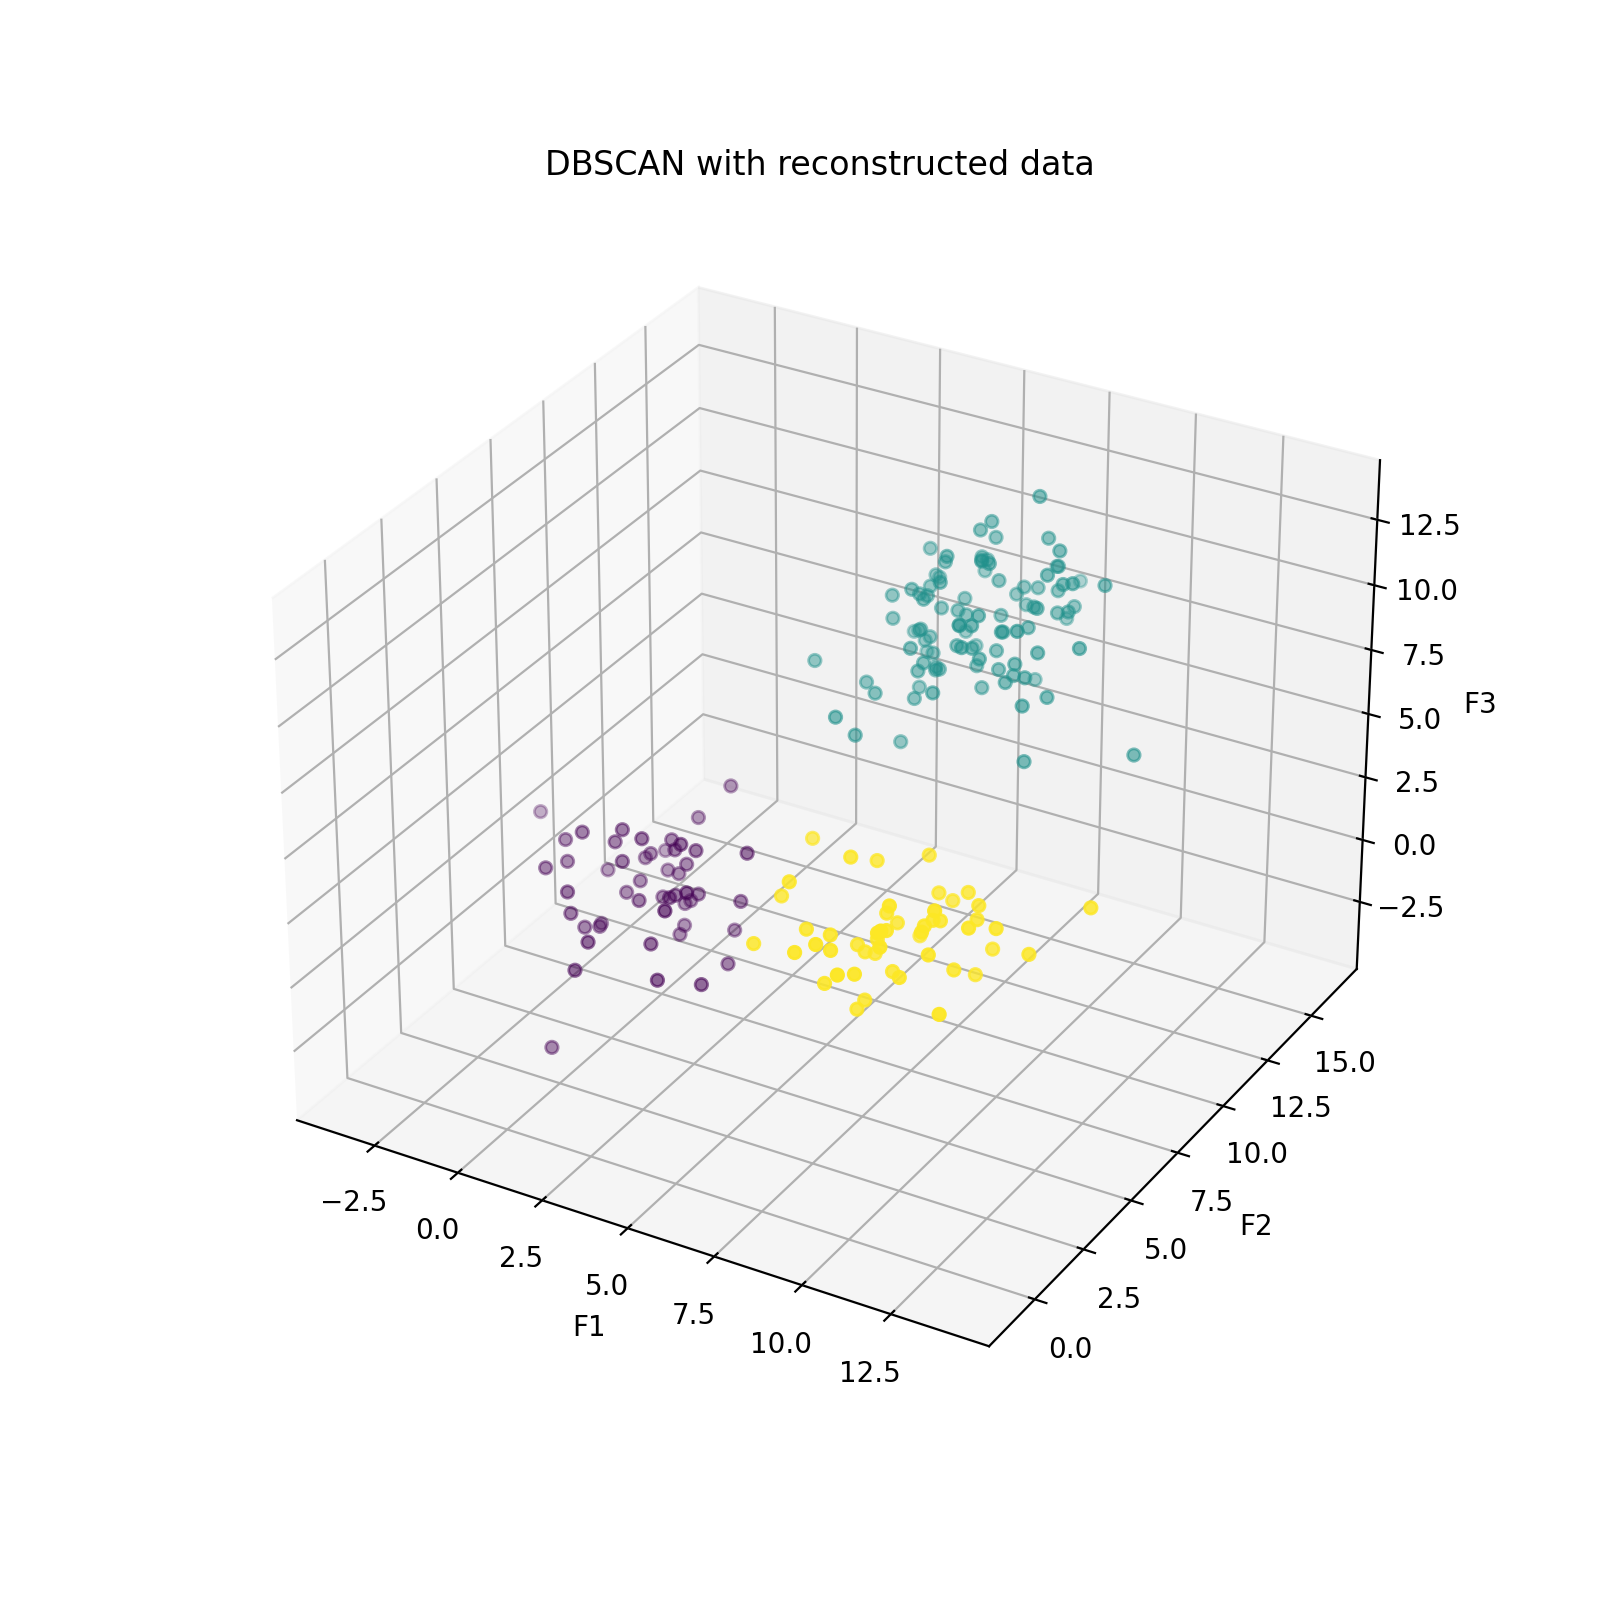

In [16]:
# plot dataset
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
plt.savefig(os.path.join(plots_path, "0_ground_truth_clusters.png"))

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [17]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), config["general"]["missing_percent"])}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

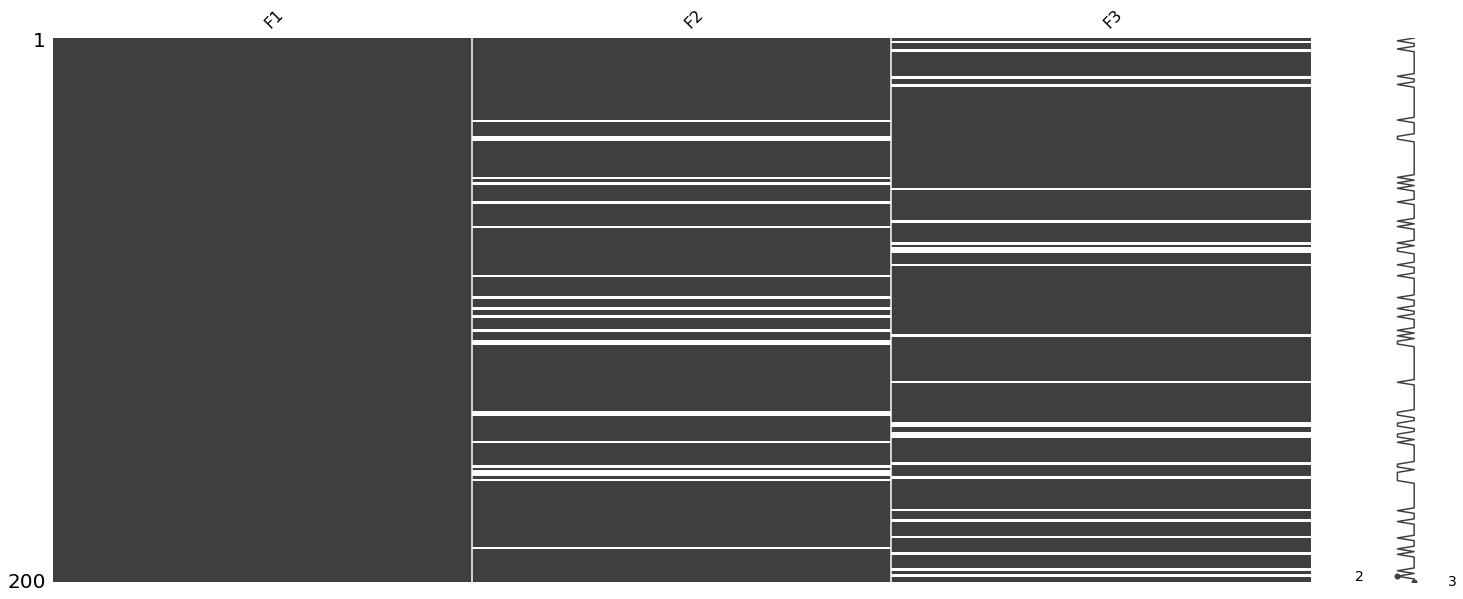

<Figure size 432x288 with 0 Axes>

In [19]:
import missingno as msno
%matplotlib inline

# plot missing values
msno.matrix(features_mv)
plt.show()
plt.savefig(os.path.join(plots_path, "missing_values.png"))

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [20]:
# run DBSCAN on original data
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


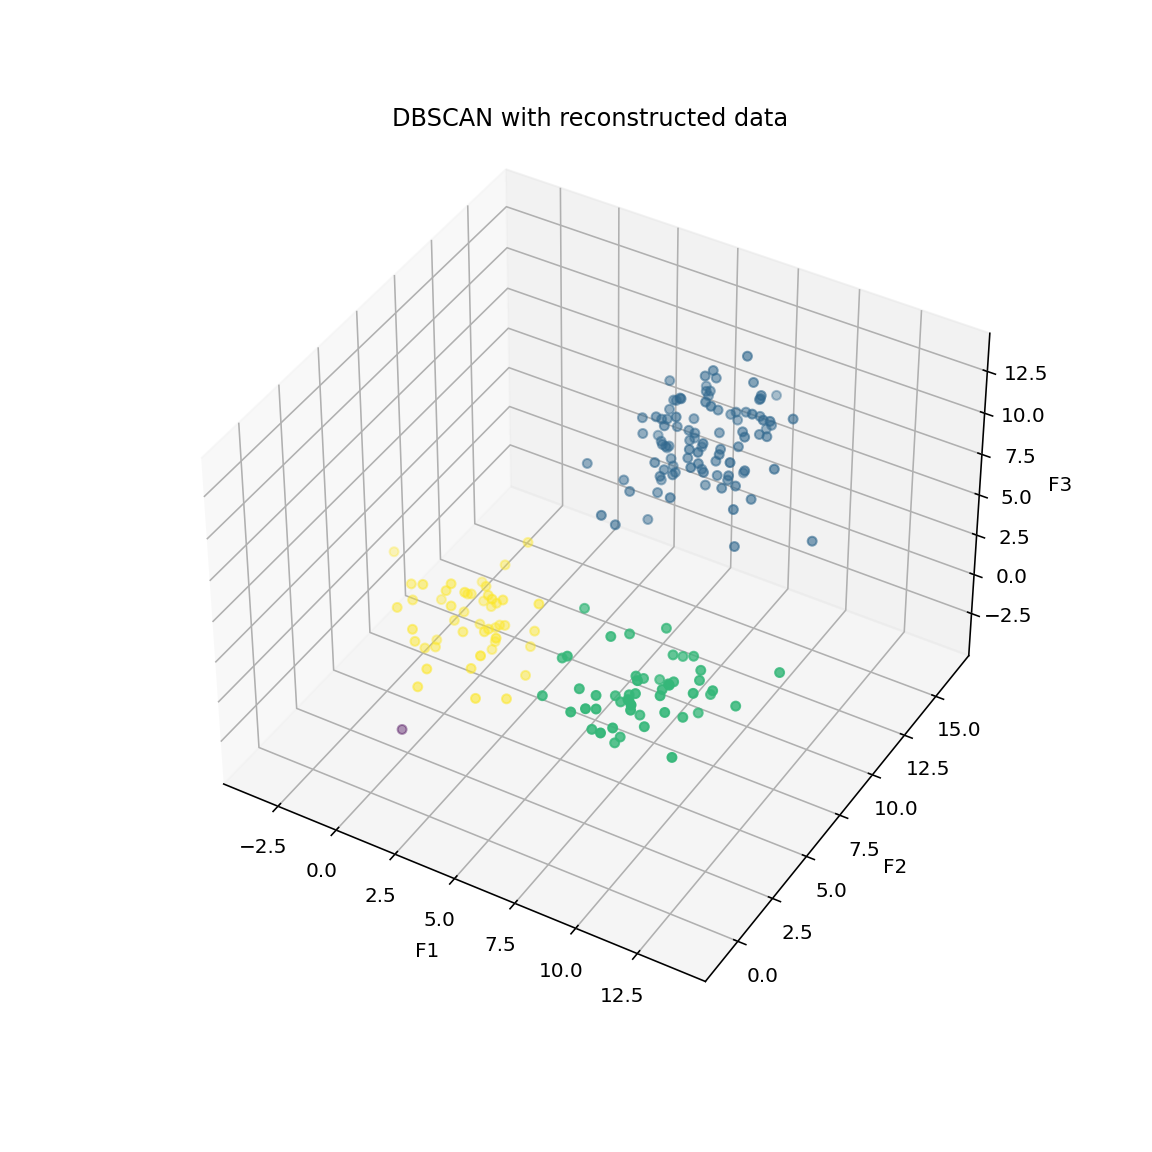

In [21]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
plt.savefig(os.path.join(plots_path, "1_DBSCAN_original_data.png"))

In [22]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [47]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        
        # KL divergence loss
        bins = 20
        dist1, dist2 = probability_dist(y_true, y_score, bins)
        KL_div_1_2 = {sum(rel_entr(dist1, dist2))}
        KL_div_2_1 = {sum(rel_entr(dist2, dist1))}
        KLdl = 
        
        # total loss
        custom_loss = cml #+ rmse
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(x, y, bins):
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

SyntaxError: invalid syntax (71603526.py, line 18)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [24]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
models = []
features_reconstr = []
costs = {}

for run in range(config["RQ2"]["runs"]):
    costs[run] = []
    for feature in features_to_predict:
        print(f"Run {run+1}, predicting {feature}")
        features_reconstr.append(features_mv.copy())

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil(config["RQ2"]["pred_features"] * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as defined in config (missing_value_mask)
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(config["general"]["missing_value_mask"])
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

        # create & train model
        model = TabNetRegressor(**regressor_param)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            **config["model_param"],
            cluster_means=cluster_means,
            target_feature=feature,
            x_val=x_val,
            y_val=y_val,
        )
        
        # add costs to dict
        costs[run].append(model.best_cost)
        
        # add model to list
        models.append(model)

        # fill missing values with model predictions
        features_reconstr[run].loc[features_reconstr[run][feature].isna(),feature] = [x[0] for x in models[len(models)-1].predict(test_data)]

Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
epoch 0  | loss: 47.64925| val_0_custom_loss: 2827.03112|  0:00:00s
epoch 1  | loss: 32.59443| val_0_custom_loss: 2798.35504|  0:00:00s
epoch 2  | loss: 20.06309| val_0_custom_loss: 2065.76546|  0:00:00s
epoch 3  | loss: 12.41566| val_0_custom_loss: 2047.35292|  0:00:00s
epoch 4  | loss: 7.05529 | val_0_custom_loss: 2358.57711|  0:00:00s
epoch 5  | loss: 4.34477 | val_0_custom_loss: 3241.20277|  0:00:00s
epoch 6  | loss: 3.50634 | val_0_custom_loss: 3912.0603|  0:00:00s
epoch 7  | loss: 3.51597 | val_0_custom_loss: 4069.01451|  0:00:00s
epoch 8  | loss: 3.55155 | val_0_custom_loss: 3858.6229|  0:00:00s
epoch 9  | loss: 3.20599 | val_0_custom_loss: 3524.52124|  0:00:00s
epoch 10 | loss: 2.64462 | val_0_custom_loss: 3209.03539|  0:00:00s
epoch 11 | loss: 2.12144 | val_0_custom_loss: 2937.64958|  0:00:00s
epoch 12 | loss: 1.80587 | val_0_custom_loss: 2691.34781|  0:00:00s
epoch 13 | loss: 1.75382 | val_0_cus

epoch 126| loss: 0.55644 | val_0_custom_loss: 485.91982|  0:00:04s
epoch 127| loss: 0.55634 | val_0_custom_loss: 484.78167|  0:00:04s
epoch 128| loss: 0.55624 | val_0_custom_loss: 483.69488|  0:00:05s
epoch 129| loss: 0.55616 | val_0_custom_loss: 482.64571|  0:00:05s
epoch 130| loss: 0.55606 | val_0_custom_loss: 481.62581|  0:00:05s
epoch 131| loss: 0.55599 | val_0_custom_loss: 480.63416|  0:00:05s
epoch 132| loss: 0.55593 | val_0_custom_loss: 479.68755|  0:00:05s
epoch 133| loss: 0.55586 | val_0_custom_loss: 478.79213|  0:00:05s
epoch 134| loss: 0.55578 | val_0_custom_loss: 477.93419|  0:00:05s
epoch 135| loss: 0.55571 | val_0_custom_loss: 477.0375|  0:00:05s
epoch 136| loss: 0.55566 | val_0_custom_loss: 476.18027|  0:00:05s
epoch 137| loss: 0.5556  | val_0_custom_loss: 475.40481|  0:00:05s
epoch 138| loss: 0.55554 | val_0_custom_loss: 474.72987|  0:00:05s
epoch 139| loss: 0.55549 | val_0_custom_loss: 474.18507|  0:00:05s
epoch 140| loss: 0.55544 | val_0_custom_loss: 473.78943|  0:00:

epoch 8  | loss: 4.43829 | val_0_custom_loss: 11338.32374|  0:00:00s
epoch 9  | loss: 3.69516 | val_0_custom_loss: 9899.02764|  0:00:00s
epoch 10 | loss: 3.34327 | val_0_custom_loss: 8842.11453|  0:00:00s
epoch 11 | loss: 2.72749 | val_0_custom_loss: 7757.38071|  0:00:00s
epoch 12 | loss: 2.75338 | val_0_custom_loss: 6848.20718|  0:00:00s
epoch 13 | loss: 2.59529 | val_0_custom_loss: 6149.31471|  0:00:00s
epoch 14 | loss: 2.25842 | val_0_custom_loss: 5593.51388|  0:00:00s
epoch 15 | loss: 1.95207 | val_0_custom_loss: 5195.64199|  0:00:00s
epoch 16 | loss: 1.77258 | val_0_custom_loss: 4904.84785|  0:00:00s
epoch 17 | loss: 1.67268 | val_0_custom_loss: 4693.22859|  0:00:00s
epoch 18 | loss: 1.72643 | val_0_custom_loss: 4448.08345|  0:00:00s
epoch 19 | loss: 1.77561 | val_0_custom_loss: 4218.08555|  0:00:00s
epoch 20 | loss: 1.83073 | val_0_custom_loss: 4016.66048|  0:00:00s
epoch 21 | loss: 1.78646 | val_0_custom_loss: 3843.16198|  0:00:00s
epoch 22 | loss: 1.68568 | val_0_custom_loss: 3

epoch 135| loss: 0.95286 | val_0_custom_loss: 578.36596|  0:00:05s
epoch 136| loss: 0.95273 | val_0_custom_loss: 575.53701|  0:00:05s
epoch 137| loss: 0.95262 | val_0_custom_loss: 572.77744|  0:00:05s
epoch 138| loss: 0.9525  | val_0_custom_loss: 570.06689|  0:00:05s
epoch 139| loss: 0.95238 | val_0_custom_loss: 567.4167|  0:00:05s
epoch 140| loss: 0.95225 | val_0_custom_loss: 564.84756|  0:00:05s
epoch 141| loss: 0.95216 | val_0_custom_loss: 562.33855|  0:00:05s
epoch 142| loss: 0.95207 | val_0_custom_loss: 559.87573|  0:00:05s
epoch 143| loss: 0.95194 | val_0_custom_loss: 557.44144|  0:00:05s
epoch 144| loss: 0.95186 | val_0_custom_loss: 555.03092|  0:00:05s
epoch 145| loss: 0.95178 | val_0_custom_loss: 552.63605|  0:00:05s
epoch 146| loss: 0.95169 | val_0_custom_loss: 550.27709|  0:00:05s
epoch 147| loss: 0.95166 | val_0_custom_loss: 547.994 |  0:00:05s
epoch 148| loss: 0.95158 | val_0_custom_loss: 545.70797|  0:00:05s
epoch 149| loss: 0.95148 | val_0_custom_loss: 543.45795|  0:00:0

epoch 260| loss: 0.95022 | val_0_custom_loss: 447.4912|  0:00:10s
epoch 261| loss: 0.95022 | val_0_custom_loss: 447.35823|  0:00:10s
epoch 262| loss: 0.95022 | val_0_custom_loss: 447.22288|  0:00:10s
epoch 263| loss: 0.95022 | val_0_custom_loss: 447.08819|  0:00:10s
epoch 264| loss: 0.95022 | val_0_custom_loss: 446.94914|  0:00:10s
epoch 265| loss: 0.95022 | val_0_custom_loss: 446.81022|  0:00:10s
epoch 266| loss: 0.95022 | val_0_custom_loss: 446.67612|  0:00:10s
epoch 267| loss: 0.95022 | val_0_custom_loss: 446.54611|  0:00:10s
epoch 268| loss: 0.95022 | val_0_custom_loss: 446.4182|  0:00:10s
epoch 269| loss: 0.95022 | val_0_custom_loss: 446.28571|  0:00:10s
epoch 270| loss: 0.95022 | val_0_custom_loss: 446.15592|  0:00:10s
epoch 271| loss: 0.95021 | val_0_custom_loss: 446.03257|  0:00:10s
epoch 272| loss: 0.95022 | val_0_custom_loss: 445.91311|  0:00:10s
epoch 273| loss: 0.95021 | val_0_custom_loss: 445.79723|  0:00:10s
epoch 274| loss: 0.95022 | val_0_custom_loss: 445.68534|  0:00:1

## 3. Complete Dataset
Costs for each run

In [25]:
costs

{0: [455.6277817531038, 442.75381721534006]}

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [26]:
cost_totals = [sum([x**2 for x in c]) for _, c in costs.items()]
best_model = cost_totals.index(min(cost_totals))
features_final = features_reconstr[best_model]
print(f"Best model: run {best_model} with custom losses {costs[best_model]} for features {list(features_to_predict)}")

Best model: run 0 with custom losses [455.6277817531038, 442.75381721534006] for features ['F2', 'F3']


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


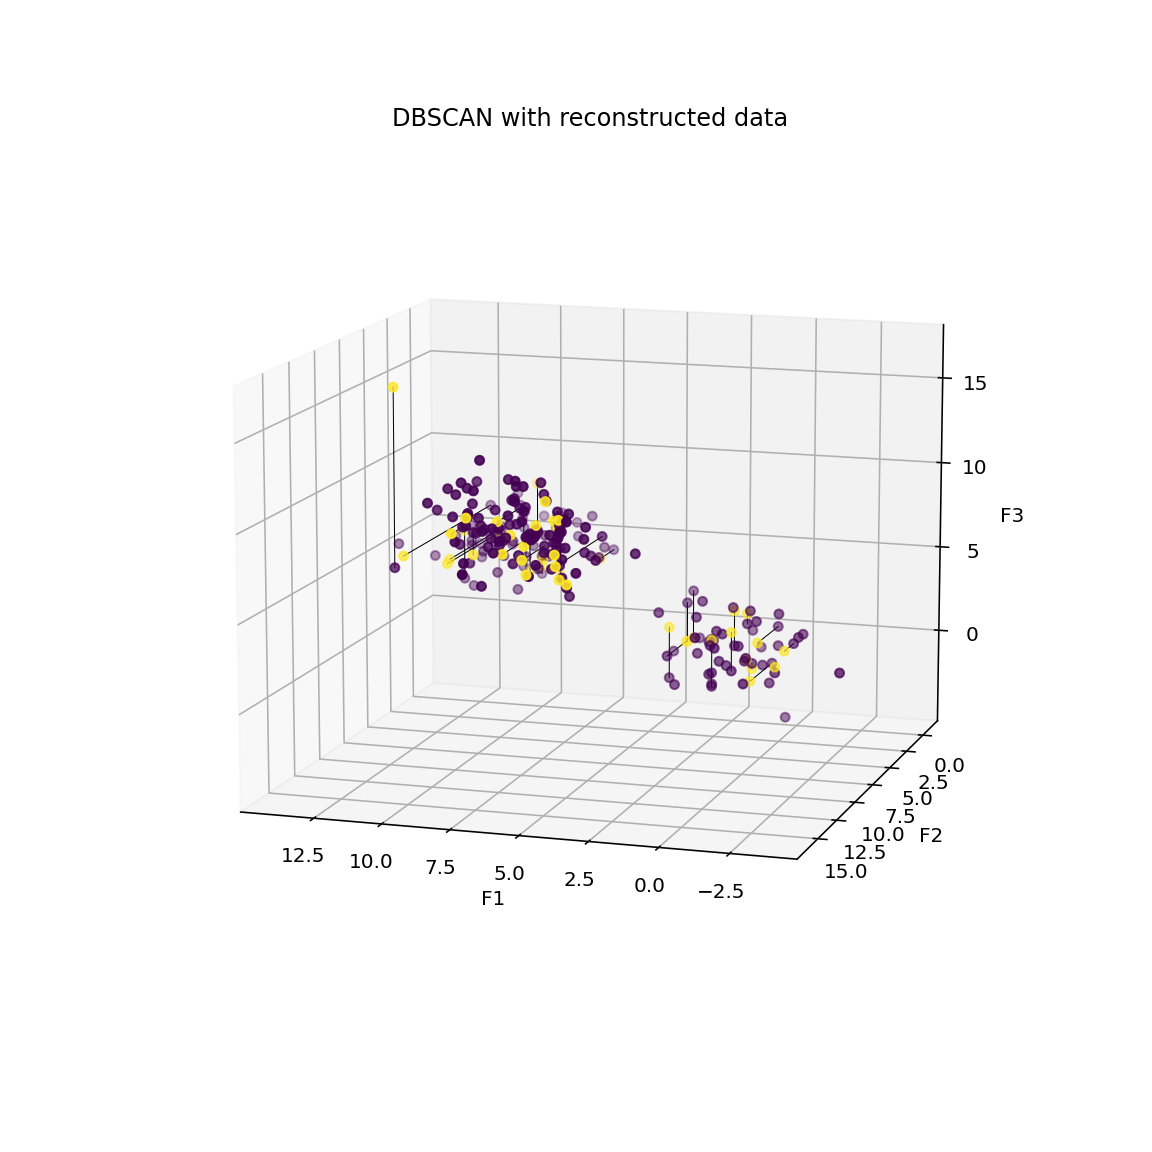

In [28]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_final[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_final[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show
plt.savefig(os.path.join(plots_path, "4_imputation_differences.png"))

## 4. Clustering

In [29]:
# apply clustering
dbscan_reconstr = DBSCAN(**config["DBSCAN"]).fit(features_final)
clusters_reconstr = dbscan_reconstr.labels_

<IPython.core.display.Javascript object>


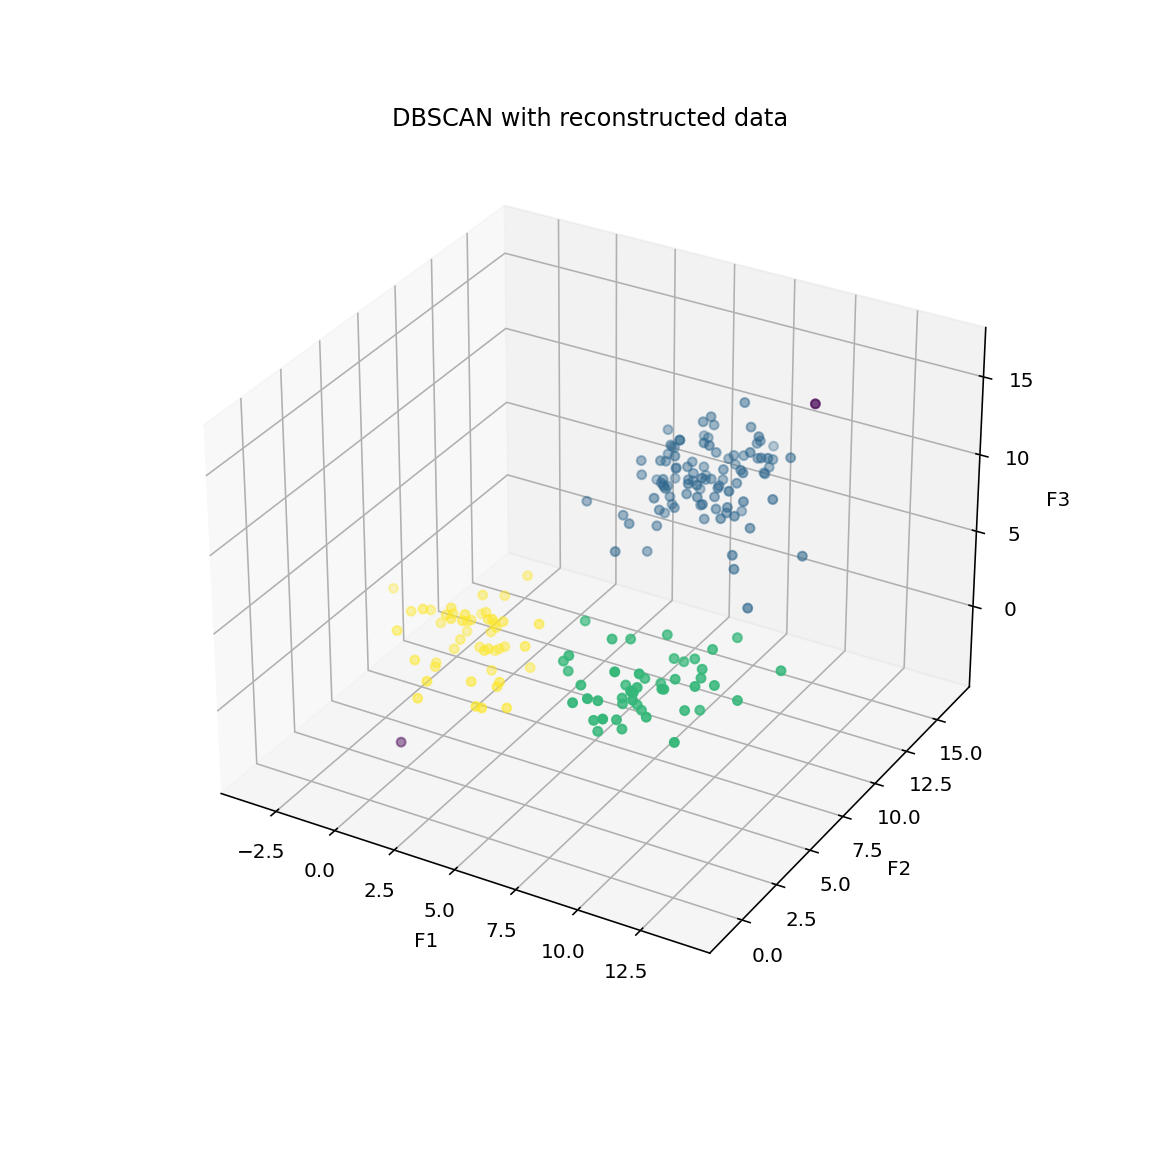

In [31]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_final.iloc[:, 0], features_final.iloc[:, 1], features_final.iloc[:, 2], c=clusters_reconstr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
plt.savefig(os.path.join(plots_path, "3_DBSCAN_imputed_data.png"))

## 5. Cluster Performance


In [37]:
results = {}

### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots

<IPython.core.display.Javascript object>


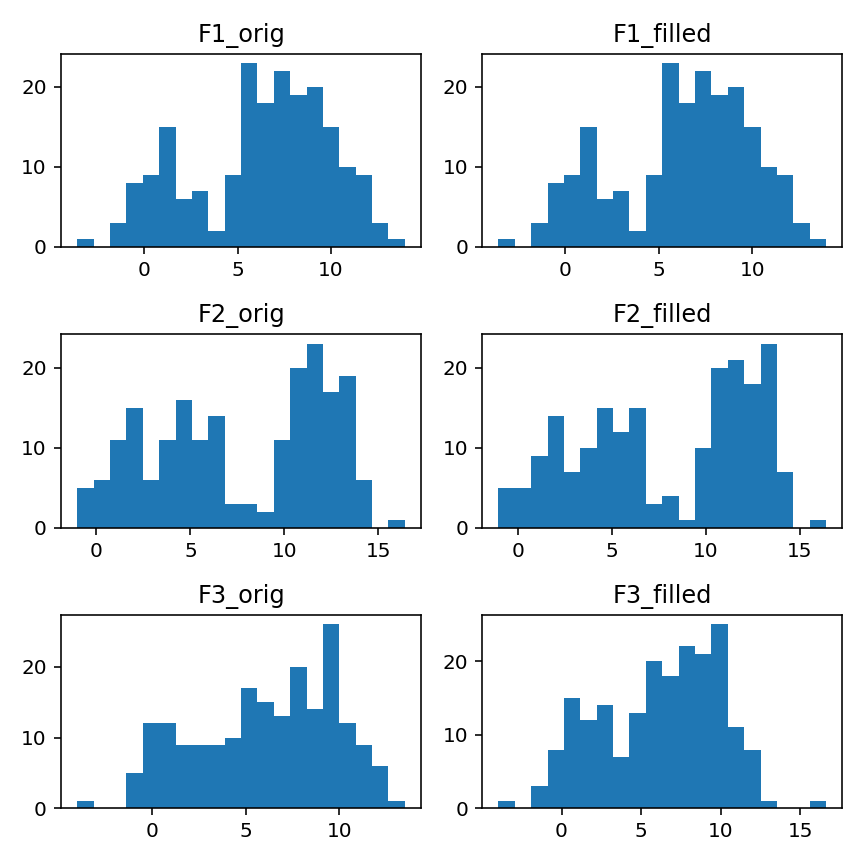

In [33]:
# plot distributions
bins = 20
n_feat = len(features_final.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_final.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_final[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()
plt.savefig(os.path.join(plots_path, "feature distributions.png"))

#### 5.1.2 KL Divergence
Based on implementation from https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula

In [45]:
# calculating the kl divergence (relative entropy) with scipy

# calculate probabilities
def probability_dist(x, y, bins):
    # histogram
    hist_xy = np.histogram2d(x, y, bins=bins)[0]

    # compute marginals
    hist_xy = hist_xy + sys.float_info.min # prevent division with 0
    hist_xy = hist_xy / np.sum(hist_xy)
    hist_x = np.sum(hist_xy, axis=1)
    hist_y = np.sum(hist_xy, axis=0)
    return(hist_x, hist_y)

# calculate kl divergence
results["KL_Divergence"] = {}
for n, feature in enumerate(features_final):
    dist1, dist2 = probability_dist(features[feature], features_final[feature], bins)
    KL_div_1_2 = {sum(rel_entr(dist1, dist2))}
    KL_div_2_1 = {sum(rel_entr(dist2, dist1))}
    results["KL_Divergence"][f"{feature}_orig --> {feature}_reconstr"] = KL_div_1_2
    results["KL_Divergence"][f"{feature}_reconstr --> {feature}_orig"] = KL_div_2_1
    
    print(f"KL divergence {feature}_orig to {feature}_filled: {KL_div_1_2}")
    print(f"KL divergence {feature}_reconstr to {feature}_orig: {KL_div_2_1}")
    print("")

KL divergence F1_orig to F1_filled: {0.0}
KL divergence F1_reconstr to F1_orig: {0.0}

KL divergence F2_orig to F2_filled: {0.008533316800716307}
KL divergence F2_reconstr to F2_orig: {0.008248045591266113}

KL divergence F3_orig to F3_filled: {53.204893759981516}
KL divergence F3_reconstr to F3_orig: {10.801061382270916}



### 5.2 Cluster Performance
#### 5.3 Noise

In [35]:
print(f"DBSCAN noise orig_data: {sum(clusters_orig == -1)}")
print(f"DBSCAN noise reconstr_data:{sum(clusters_reconstr == -1)}")

DBSCAN noise orig_data: 1
DBSCAN noise reconstr_data:2


#### 5.4 Silhouette Score

In [42]:
from sklearn.metrics import silhouette_score

silhouette_orig = silhouette_score(features, np.ravel(clusters))
silhouette_reconstr = silhouette_score(features_final, clusters_reconstr)

results["silhouette_score"] = {}
results["silhouette_score"]["orig_data"] = silhouette_orig
results["silhouette_score"]["reconstr_data"] = silhouette_reconstr
print(f"Silhouette Score orig_data: {silhouette_orig}")
print(f"Silhouette Score reconstr_data: {silhouette_reconstr}")

Silhouette Score orig_data: 0.686605699880095
Silhouette Score reconstr_data: 0.6670414032296427
